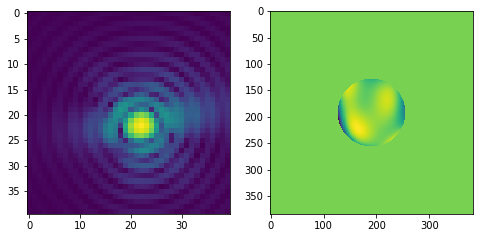

In [215]:
from astropy.io import fits
import numpy as np
import numpy.fft as FFT
import aotools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
import aotools
%matplotlib inline

nbZernike=15
pupilSize=128
padding=128
rmsPerMode=0.4

Zs = aotools.zernikeArray(nbZernike + 1, pupilSize, norm='rms')

coeffs = (np.random.random(nbZernike)-0.5) * rmsPerMode
coeffs[0:2]=0

# Pupil mask
mask = aotools.circle(pupilSize/2, pupilSize)
phase = np.squeeze(np.sum(coeffs[ :, None, None] * Zs[1:, :,:], axis=0))

phase_pad = np.pad(phase, (padding, padding),
                   mode='constant', constant_values=0)
mask_pad = np.pad(mask, (padding, padding),
                  mode='constant', constant_values=0)

Efield = mask_pad * np.exp(1j * phase_pad)
psf = np.absolute(FFT.fftshift(FFT.fft2(FFT.ifftshift(Efield))))**2
psf /= np.sum(psf)

plt.figure(figsize=(8, 6))
plt.subplot(121)
psf_cropped=psf[170:210, 170:210]
#psf_cropped = psf
plt.imshow(psf_cropped, norm=ImageNormalize(psf_cropped, stretch=LogStretch()))

plt.subplot(122)
plt.imshow(phase_pad) #[128:256, 128:256])

In [216]:
### GOX

n_iteration = 200

amp = np.sqrt(np.abs(psf))
#A  = FFT.fftshift(FFT.ifft2(FFT.fftshift(psf)))
A = FFT.ifftshift(FFT.ifft2(FFT.fftshift(amp *np.exp(1j))))

for i in range(n_iteration):
    B = mask_pad * np.exp(1j * np.angle(A))
    C = FFT.fftshift(FFT.fft2(FFT.ifftshift(B)))
    D = amp * np.exp(1j * np.angle(C))
    A = FFT.ifftshift(FFT.ifft2(FFT.fftshift(D)))
  
retrieved_phase =  mask_pad * np.angle(A)

# Convert radiant to nanometer
#wavelength = 2200 # in nm -> 2.2e-6 m
#retrieved_phase = retrieved_phase * (wavelength / (2*np.pi))


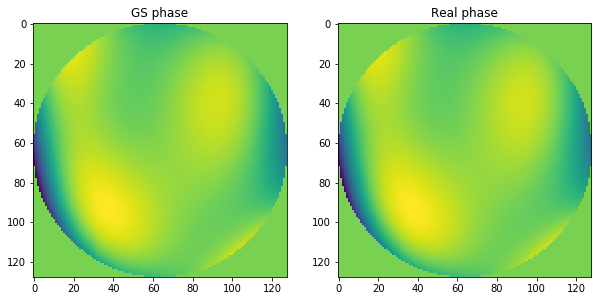

In [217]:
from unwrap import unwrap
# Show phase
f, axarr = plt.subplots(1,2, figsize=(10, 10))
#axarr[0].imshow(-mask*(retrieved_phase[128:256, 128:256]))
axarr[0].imshow(mask*(retrieved_phase[128:256, 128:256] - mask))
axarr[0].set_title("GS phase")
axarr[1].imshow(phase_pad[128:256, 128:256])
axarr[1].set_title("Real phase")
plt.show()